# Philadelphia Housing Sale Price Predictor 

## Models 
Below are various models that will predict the sale price of homes in Philadelphia. The models Used are: 
- Linear Regression
- Decision Trees
- Random Forest 
- Gradeint Boosting 

## Data
Data is gathered from the city of philadelphia website for property data: https://www.phila.gov/property/data/

### Data Preprocessing 
Data from this dataset underwent extensive cleaning and preprocessing. Below are some of the main preprocessing techniques used to parse the data:
- Principle Component Analysis (PCA)
- One-hot Encoding 
- Binary Encoding 
- Inter-Quartile Range (IQR) 

# Importing and Analysing the dataset
below, I import the necessary libraries to process the data set and load in the dataset itself. I also perform some preliminary analysis on the data to get some basic statistics and the shape of the dataset. 

In [311]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns # advanced plotter 

raw_data = pd.read_csv(r'opa_properties_public.csv') 

# target is the sale_price attribute 
target = raw_data['sale_price']

print("\n\tData Statistics: ")
print(f"Data Shape: { raw_data.shape }")
#print(f"Statistics: { housing_data.describe }")

print("\n\tDataset Attributes:")
print(f"Attributes: {raw_data.columns}")



C:\Users\aaron\AppData\Local\Temp\ipykernel_8860\1581772330.py:6: DtypeWarning: Columns (5,26,49,77) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(r'opa_properties_public.csv')



	Data Statistics: 
Data Shape: (582933, 82)

	Dataset Attributes:
Attributes: Index(['the_geom', 'the_geom_webmercator', 'assessment_date', 'basements',
       'beginning_point', 'book_and_page', 'building_code',
       'building_code_description', 'category_code',
       'category_code_description', 'census_tract', 'central_air',
       'cross_reference', 'date_exterior_condition', 'depth',
       'exempt_building', 'exempt_land', 'exterior_condition', 'fireplaces',
       'frontage', 'fuel', 'garage_spaces', 'garage_type',
       'general_construction', 'geographic_ward', 'homestead_exemption',
       'house_extension', 'house_number', 'interior_condition', 'location',
       'mailing_address_1', 'mailing_address_2', 'mailing_care_of',
       'mailing_city_state', 'mailing_street', 'mailing_zip', 'market_value',
       'market_value_date', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_of_rooms', 'number_stories', 'off_street_open',
       'other_building', 'owner_1', '

### Dropping Useless Attributes 

after sifting through the data there were many attributes that fit into the following categories:
- redundant (mailing_address_1 AND mailing_address_2 for example)
- uninformative (book_and_page, assesment_date etc.)

Some attributes were dropped due to the fact that they would simply add noise to the ML models those are given below: 
- street_name - dropped since streets may run all throughout the city and the same street may have homes of different prices 

In [312]:
# attributes to be dropped
to_drop = ['the_geom', 'assessment_date', 'beginning_point', 'book_and_page', 
    'category_code_description', 'cross_reference', 'house_number', 'location', 
    'mailing_address_1', 'mailing_address_2', 'mailing_care_of', 'mailing_city_state', 
    'mailing_street', 'market_value_date', 'the_geom_webmercator', 'other_building', 
    'owner_1', 'owner_2', 'parcel_number', 'recording_date',  'registry_number', 
    'unit', 'objectid', 'building_code', 'census_tract', 
    'date_exterior_condition', 'year_built_estimate', 'house_extension', 'mailing_zip', 
    'sewer', 'site_type', 'state_code', 'street_designation', 'street_name', 
    'street_direction', 'geographic_ward', 'parcel_shape', 'building_code_new', 'zoning', 
    'exempt_land', 'off_street_open', 'pin', 'general_construction', 'sale_date', 'street_code', 'view_type', 'lat', 'lng','topography']


# dropping the attributes and setting up our main 'data' dataframe 
data = raw_data.drop(to_drop, axis=1)


### Handling Missing Values and NaNs
 

first will look directly at our target attribute ('sale_price') and drop missing values from it. In this step, I will only handle the removal of...
- missing values
- place holder values (0 or 1)

In [313]:
# analyzing target attribute: sale_price 
print(f"Missing Values in Target: {target.isnull().sum()}") # 2534 missing values 

# dropping rows with missing 'sale_price' values 
data = data.dropna(subset=['sale_price'])

# checking if dataset has any place holders and dropping them 
place_holder_rows = data[data['sale_price'] <= 1]
print(f"Rows with sale Price as 1 or 0: {len(place_holder_rows)}") # 157670 rows

# dropping place holder values of 0 or 1 
data = data.drop(data[data.sale_price <= 1].index)



Missing Values in Target: 2534
Rows with sale Price as 1 or 0: 157670


Now, I'll gather some data about missing values in attrbiutes other than the target. I do this by generating some data and graphs about collumns with some amount of data missing. I feel that it is justified to drop rows from the dataset if the total amount of missing values in a given column is at most 5% of the the number of usable rows, that is i'll set my threshold to 5% of len(data).

Max Missing Data Threshold: 21136.45


Text(0, 0.5, 'Feature Name')

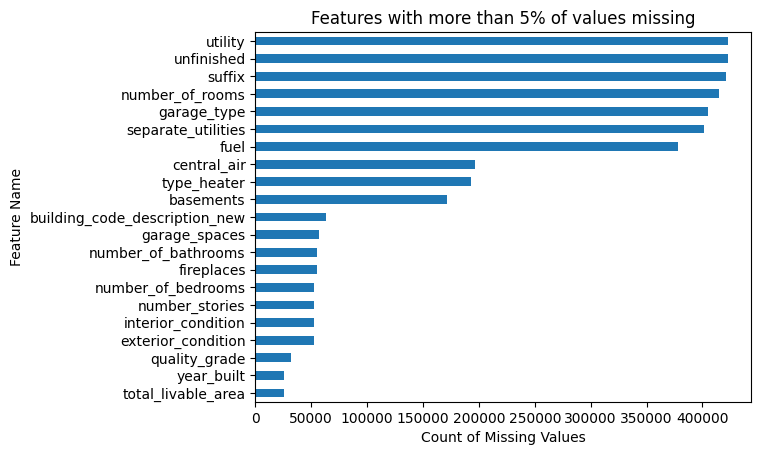

In [314]:
# graph of missing data attributes 
missing_data_threshold = 0.05 * len(data)
print(f"Max Missing Data Threshold: {missing_data_threshold}") # 5% of the data equates to roughly 20,500 rows 

missing = data.isnull().sum()
missing = missing[missing >= missing_data_threshold]
missing.sort_values(inplace=True)

missing.plot.barh() 
plt.title("""Features with more than 5% of values missing""")
plt.xlabel("Count of Missing Values")
plt.ylabel("Feature Name")

This bar chart provides some important insights. The most glaring of which are that attributes like 'utility', 'unfinished', 'suffix', 'number_of_rooms' etc. Have nearly **ALL** of their rows missing! I will need to either drop or impute these values as well as perform some analysis on their actual meanings as well. I will use these notes as a reference to the meaning of these attributes:

### Dropping Features With High Quantities of Missing Data

In [315]:
# selecting attributes to drop
attrs_exceed_missing = ['utility', 'unfinished', 'suffix', 'garage_type', 'number_of_rooms',
'separate_utilities', 'fuel', 'basements', 'central_air', 'type_heater', 'basements', 'building_code_description_new']

# dropping the attributes 
data = data.drop(attrs_exceed_missing, axis=1)


print(f"Total Columns Remaining: { data.shape[1] }")

Total Columns Remaining: 22


### Understanding the Features

_Category code_: the type of a particular building

| Code | Count  | Description       |
|------|--------|-------------------|
| 1    | 426976 | Single Family     |
| 6    | 44928  | Vacant Land       |
| 2    | 41538  | Multi Family      |
| 3    | 14489  | Mixed Use         |
| 4    | 13125  | Commercial        |
| 5    | 4286   | Industrial        |

I will only consider single family homes for the following reasons:
- they represent the majority of the data set (about 78%)
- vacant, industrial, commercial land is not relevant
- mixed use is vague (probably business and homes in same building)
- multi family is fairly small (roughly 10% of the homes) and difficult to interpret on a single household basis 





In [316]:
# keeping only single family designated homes  
data = data[data['category_code'] == 1]
print(len(data)) # 332307 homes remain 

340327


_Depth_: not clear what depth is - most likely depth of the home
the data is set to 0 at some points which seems to be a place holder and doesnt make sense (a house cant have a depth of 0). I will drop all rows with depth=0

In [317]:
# dropping all rows with a depth of 0
data = data.drop(data[data.depth == 0].index)
print(len(data)) # 305633

313087


_lng & lat_ - these represent the latitude and longitude of the homes. I feel that this data is important for predicting sale price since certain locations will contain homes more expensive than others and latitude and longitude are quite precise unlike zip code, which may contain a wide variety of sale prices. I will first check how many rows are missing either lat, lng, or both. Since these are precise measurements, imputation will not make much sense here so i will see if its usefull to apply them to my models if i do not need to drop too many rows. it turns out (below) that there are only 7 missing rows, so i will just drop those homes. 

In [318]:
# rows with missing position data 
#missing_lat_lng = data[data['lat'].isnull() | data['lng'].isnull()]

# number of rows 
#print(f"{len(missing_lat_lng)} have missing data in either lat or lng") # only 7 missing rows, so ill just drop them 

# dropping the rows with either missing lat or lng (or both)
#data = data.dropna(subset=['lat', 'lng'])

# total usable rows remaining 
#print(f"Number of Usable Rows: { len(data) }")
#print(f"Verifying lat and lng have 0 missing values: {data['lat'].isnull().sum(), data['lng'].isnull().sum()}")


_zip_code_: the zipcode of where the home is located. This will be treated as a categorical vairable (encoding will happen later after cleaning).
first zip codes in this dataset are given in the following format: `18974-0000`. We need to drop the hyphen. 
Also, I will look at the density of homes within each zip code and really only consider densly populated zip codes as they represent the cost of homes within the greater philadelphia area. 

In [319]:
# getting the number of zipcodes 
zip_codes = data.zip_code.value_counts(dropna=False)
print(f"Distinct Zip Codes: {len(zip_codes)}") # 47 zipcodes 
print(data['zip_code'].isnull().sum()) # only 7 rows with missing zip codes so we can drop

data = data.dropna(subset=['zip_code'])
    # formatting the zips 

# cutting everything after 5 chars and all strings 
new_zip_values = data['zip_code'].apply(lambda x: f"{int(str(x).strip()[:5]):05d}")

# converting to int and inserting into the zip_code col
data['zip_code'] = new_zip_values.astype('int64', errors='ignore')

print(f"Type of all zipcodes: {data['zip_code'].dtype}") # verifying this worked 


Distinct Zip Codes: 48
7
Type of all zipcodes: int64


_exterior_condition_ - this seems like an important metric to keep around since it doesnt have too many missing values and can reasonably expected to correlate with the sale price. The Following Codes are given for the designations: 

| Numerical Value | Category Label                           |
|-----------------|------------------------------------------|
| 0.0             | Not Applicable                           |
| 1.0             | New                          |
| 2.0             | Newer Construction / Rehabbed            |
| 3.0             | Above Average                            |
| 4.0             | Average                                  |
| 5.0             | Below Average                            |
| 6.0             | Vacant                                   |
| 7.0             | Sealed / Structurally Compromised        |




 I will then try to visualize the market value - exterior condition relationship with a box plot below: 

Number of Usable Rows: 313080


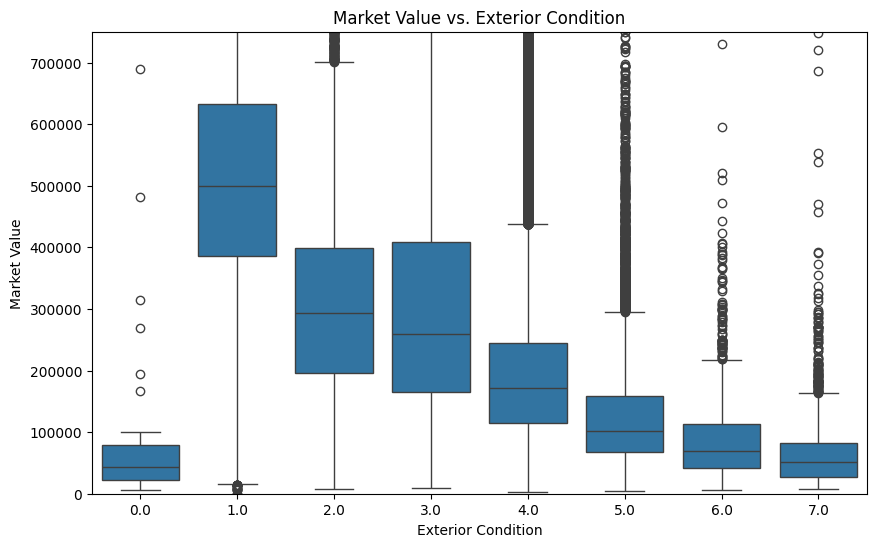

In [320]:
print(f"Number of Usable Rows: {len(data)}")

# making the box plot
plt.figure(figsize=(10, 6))  
sns.boxplot(x='exterior_condition', y='market_value', data=data)


# setting the limits so its easier to see the bars 
plt.ylim(0, 750000)

plt.title('Market Value vs. Exterior Condition')
plt.xlabel('Exterior Condition')
plt.ylabel('Market Value')
plt.show()

_interior_condition_: similarly, we can observe the trends of the interior condition with respect to market value 


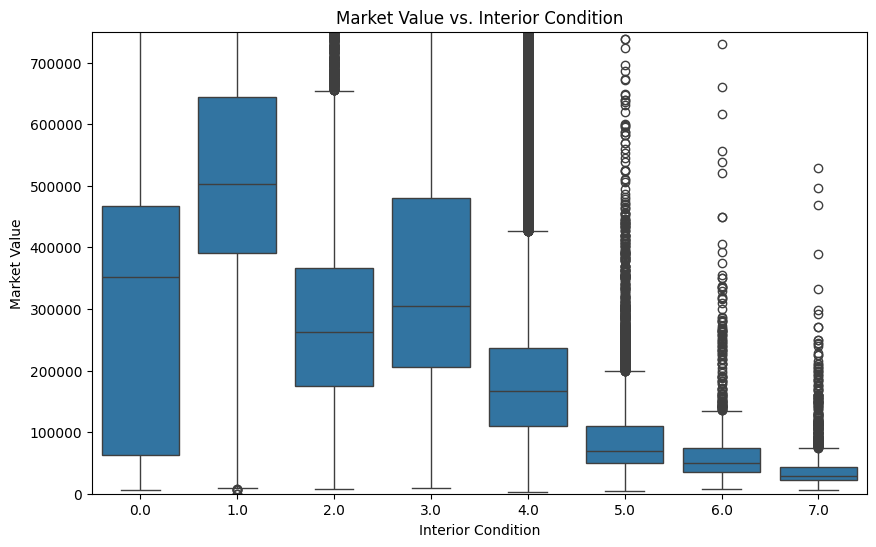

In [321]:

# making the box plot
plt.figure(figsize=(10, 6))  
sns.boxplot(x='interior_condition', y='market_value', data=data)


# setting the limits so its easier to see the bars 
plt.ylim(0, 750000)

plt.title('Market Value vs. Interior Condition')
plt.xlabel('Interior Condition')
plt.ylabel('Market Value')
plt.show()

I will drop all Nan Rows for interior_condition and exterior_condition 

In [322]:
# dropping Nans from these attributes 
data = data.dropna(subset=['exterior_condition'])
data = data.dropna(subset=['interior_condition'])

_quality_grade_ - the rating of quality of the home I will inspect the unique quality grades and count the missing values below.

Since the majority of the data exists within the valid_grades rating system I defined (a subset of all possible quality grades, I will just keep those). 
Since, after plotting a grade of 'C' is by far the most common rating, i feel it is reasonable to impute the 1325 missing values (Nans) with the grade of C. This makes intuitive sense since C corresponds to Average. 


Unique Quality Grades: ['B ' 'C ' 'C+' nan 'A-' 'D ' 'B+' 'A ' 'D+' 'D-' 'B-' 'C-' 'E+' 'E ' 'A+'
 '3 ' 'S ' 'E-' 'X-' '4 ' '5 ' '6 ' 'X ' 'S+' 'S-' 'X+']
NaN Quality Scores: 3881
Number of Grades in Logical Grading setup (A+, A, A-...): 308536


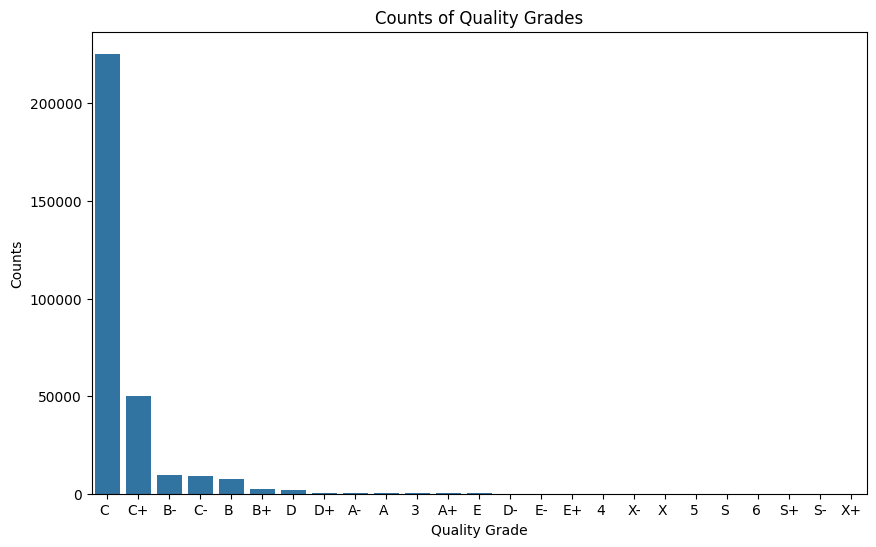

In [323]:
    # unique grades for quality_grade

# choosing grades that are interpretable
valid_grades = ['A+', 'A ', 'A-', 'B+', 'B ', 'B-', 'C+', 'C ', 'C-', 'D+', 'D ', 'D-', 'E+', 'E ']

# summing number of valid grades 
valid_grade_count = data['quality_grade'].isin(valid_grades).sum()

print(f"Unique Quality Grades: {data['quality_grade'].unique()}")
print(f"NaN Quality Scores: {data['quality_grade'].isnull().sum()}")
print(f"Number of Grades in Logical Grading setup (A+, A, A-...): {valid_grade_count}")

# counting values for all unique grades
grade_counts = data['quality_grade'].value_counts()

# plotting 
plt.figure(figsize=(10, 6))
sns.barplot(x=grade_counts.index, y=grade_counts.values)

plt.title('Counts of Quality Grades')
plt.xlabel('Quality Grade')
plt.ylabel('Counts')

plt.show()

Below, i will replace all quality grade values that are `Nan` with a 'C' and then drop those that arent in `valid_grades`

In [324]:
# imputing the to the Nans 
data['quality_grade'].fillna('C', inplace=True)

# dropping grades not in valid_grades
data = data[data['quality_grade'].isin(valid_grades)]
print(len(data))

# verify it worked 
print(data['quality_grade'].isnull().sum()) 

308536
0


C:\Users\aaron\AppData\Local\Temp\ipykernel_8860\1001785022.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['quality_grade'].fillna('C', inplace=True)


### Analysis and Nan Handling Summary

Above has been the majority of the work of dealing with dropping values, dealing with Nans and analyzing the data to get some preliminary results. The next part will involve feature engineering. 

# Feature Engineering 
In this section, I will: 
- analyze correlations between attributes and the target (market value)
- impute missing values 
- encode data appropriately 
- scale the data
- standardize the data 
- perform outlier analysis and removal 

First, I will visualize the correlation between various attributes and the market value of homes over this data set (im only looking at numerical data at this moment)

In [344]:
numerical_data = data.select_dtypes(include=['number'])
market_value_correlation = numerical_data.corr()
market_value_correlation.sort_values(['market_value'], ascending=False, inplace=True)

print("Correlation Values for Each Numerical Attribute to the Target:\n")
print(market_value_correlation.market_value)

# dropping things with less than 15% correlation to market value 
target_corr = market_value_correlation["market_value"]
filtered_columns = market_value_correlation[abs(target_corr) > 0.15].index
df_scaled = df_scaled[filtered_columns]

Correlation Values for Each Numerical Attribute to the Target:

market_value                  1.000000
taxable_land                  0.983372
taxable_building              0.814869
total_livable_area            0.632024
exempt_building               0.466794
fireplaces                    0.351912
frontage                      0.325781
number_stories                0.263535
total_area                    0.222001
number_of_bathrooms           0.220777
garage_spaces                 0.191902
depth                         0.174909
year_built                    0.174295
homestead_exemption           0.130289
sale_price                    0.039246
number_of_bedrooms           -0.058930
zip_code                     -0.109045
quality_grades_encoded       -0.266589
exterior_condition           -0.383202
exterior_condition_encoded   -0.383202
interior_condition           -0.428652
interior_condition_encoded   -0.428652
category_code                      NaN
Name: market_value, dtype: float64


NameError: name 'df_scaled' is not defined

### Selecting and Encoding Categorical Data

Since i will need to see how categorical attributes also affect the data, well need to encode them. I have selected the following attributes by eliminating those that had large quantities of missing values and were not relevant (such as adresses and pin codes). 

- exterior_condition
- fireplaces
- general_construction 
- interior_condition
- quality_grade
- year_built

### Ordinally Encoded Data
this data will be ordinally encoded as they are "grades" of quality 

In [326]:
from sklearn.preprocessing import OrdinalEncoder 

exterior_condition_grades = sorted(data['exterior_condition'].unique().astype(int))
interior_condition_grades = sorted(data['interior_condition'].unique() .astype(int))
quality_grades = sorted(data['quality_grade'].unique())

# encdoing exterior condition 
exterior_condition_encoder = OrdinalEncoder(categories=[exterior_condition_grades])
data['exterior_condition_encoded'] = exterior_condition_encoder.fit_transform(data[['exterior_condition']])

# encdoing interior condition 
interior_condition_encoder = OrdinalEncoder(categories=[interior_condition_grades])
data['interior_condition_encoded'] = interior_condition_encoder.fit_transform(data[['interior_condition']])

# encoding quality grade 
quality_grade_encoder = OrdinalEncoder(categories=[quality_grades])
data['quality_grades_encoded'] = quality_grade_encoder.fit_transform(data[['quality_grade']])


After analysis of the data, I set hard limits based on the counts and ragnes of values for each numerical attribute. This is due to the overwheling majority of the data being in a given range and only a small percentage (roughly 1-2%) skewing right in the features below. I therefore only kept the mean features and essentially arrived at a normal distribution. 

In [327]:
depth_bounds = [0, 400]
frontage_bounds = [0, 400]
garage_bounds = [0, 2]
number_of_bathrooms_bounds = [0, 4]
number_of_bedrooms_bounds = [0, 6]
number_of_stories_bounds = [1,3]

# dropping outliers 
data = data[(data['depth'] >= depth_bounds[0]) & (data['depth'] <= depth_bounds[1])]
data = data[(data['frontage'] >= frontage_bounds[0]) & (data['frontage'] <= frontage_bounds[1])]
data = data[(data['garage_spaces'] >= garage_bounds[0]) & (data['garage_spaces'] <= garage_bounds[1])]
data = data[(data['number_of_bathrooms'] >= number_of_bathrooms_bounds[0]) & (data['number_of_bathrooms'] <= number_of_bathrooms_bounds[1])]
data = data[(data['number_of_bedrooms'] >= number_of_bedrooms_bounds[0]) & (data['number_of_bedrooms'] <= number_of_bedrooms_bounds[1])]
data = data[(data['number_stories'] >= number_of_stories_bounds[0]) & (data['number_stories'] <= number_of_stories_bounds[1])]

In [339]:
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

# iqr thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# ilter out the outliers
y_filtered = y[(y >= lower_bound) & (y <= upper_bound)]

print(len(y_filtered))

284562


### Final Analysis
After working with the data, we are now able to see the final count of missing values that need to be corrected. Below are some results that im happy with so i will now begin. To train my models 

In [328]:
total = data.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print(missing_data)

# final drop of nans
data = data.dropna() 


                            Total   Percent
fireplaces                    112  0.036941
building_code_description       3  0.000990
taxable_building                1  0.000330
number_stories                  0  0.000000
interior_condition_encoded      0  0.000000
exterior_condition_encoded      0  0.000000
zip_code                        0  0.000000
year_built                      0  0.000000
total_livable_area              0  0.000000
total_area                      0  0.000000
taxable_land                    0  0.000000
sale_price                      0  0.000000
quality_grade                   0  0.000000
number_of_bedrooms              0  0.000000
category_code                   0  0.000000
number_of_bathrooms             0  0.000000
market_value                    0  0.000000
interior_condition              0  0.000000
homestead_exemption             0  0.000000
garage_spaces                   0  0.000000
frontage                        0  0.000000
exterior_condition              

In [329]:
# final count of columns 
print(data.shape)

(303067, 25)


# Model Construction 
now we move on to building the models. 

Final feature set: 

features = ['depth', 'exempt_building', 'exterior_condition_encoded', 'fireplaces', 
            'frontage', 'garage_spaces', 'homestead_exemption', 'interior_condition_encoded', 
            'number_of_bathrooms', 'number_of_bedrooms', 'number_stories', 
            'quality_grades_encoded', 'taxable_building', 'taxable_land', 'total_area', 
            'total_livable_area', 'year_built', 'zip_code']


### Linear Regression 

In [340]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Selecting features - excluding non-encoded categorical columns
all_features = ['depth', 'exempt_building', 'exterior_condition_encoded', 'fireplaces', 
            'frontage', 'garage_spaces', 'homestead_exemption', 'interior_condition_encoded', 
            'number_of_bathrooms', 'number_of_bedrooms', 'number_stories', 
            'quality_grades_encoded', 'taxable_building', 'taxable_land', 'total_area', 
            'total_livable_area' ,'market_value'] # drop market value later!!!!!!!!!!!!!

all_data = data[all_features]

# scaling the data since we have huge differences in magnitude between attributes

scaler = StandardScaler()
all_scaled = scaler.fit_transform(all_data)

X_scaled = all_scaled.drop(columns=['market_value']) # features
y_scaled = all_scaled['market_value'] # target 

# Splitting the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=5)
# Creating the Linear Regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Predicting the target values for the test set
y_pred = model.predict(X_test)

# Calculating the metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

AttributeError: 'numpy.ndarray' object has no attribute 'drop'